In [1]:
import torch
from matplotlib import pyplot as plt
import copy

In [2]:
from ili.dataloaders import SummarizerDatasetLoader
from ili.inference import InferenceRunner
from ili.validation import ValidationRunner
from ili.validation.metrics import PlotSinglePosterior,PosteriorCoverage
from ili.utils.samplers import DirectSampler

In [3]:
# Define configuration file paths
cfgdata = "datasets/ili_cfg/quijote/quijote_datacfg.yaml"
cfginfer = "datasets/ili_cfg/quijote/quijote_infercfg.yaml"
cfgval = "datasets/ili_cfg/quijote/quijote_valcfg.yaml"

# Create dataloaders
train_loader = SummarizerDatasetLoader.from_config(cfgdata, stage='train')
val_loader = SummarizerDatasetLoader.from_config(cfgdata, stage='val')

train_data = train_loader.get_all_data()
train_thetas = train_loader.get_all_parameters()

val_data = val_loader.get_all_data()
val_thetas = val_loader.get_all_parameters()

In [4]:
# Train a model to infer x -> theta. Save it as toy/posterior.pkl
runner = InferenceRunner.from_config(cfginfer)
pos_npe,summaries= runner(loader=train_loader)

# Use the trained posterior model to predict on a single example from the test set
# val_runner = ValidationRunner.from_config(cfgval)
# val_runner(loader=val_loader)

INFO:root:MODEL INFERENCE CLASS: NPE
/home/suice/miniconda3/envs/delfi/lib/python3.8/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 1 / 1.


 Training neural network. Epochs trained: 38

/home/suice/miniconda3/envs/delfi/lib/python3.8/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 13.528637886047363 seconds to train models.
INFO:root:Saving model to toy


 Neural network successfully converged after 39 epochs.

In [5]:
single_pos_sampler=PlotSinglePosterior(num_samples=100,save_samples=True,out_dir='toy',sample_method='direct')
pos_coverage_sampler=PosteriorCoverage(num_samples=100,plot_list=["coverage", "histogram", "predictions"],sample_method='direct',labels=[ 'Omega_m', 'h', 'sigma_8' ])

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Saving single posterior plot to toy/plot_single_posterior.jpg...
INFO:root:Saving single posterior samples to toy/single_samples.npy...


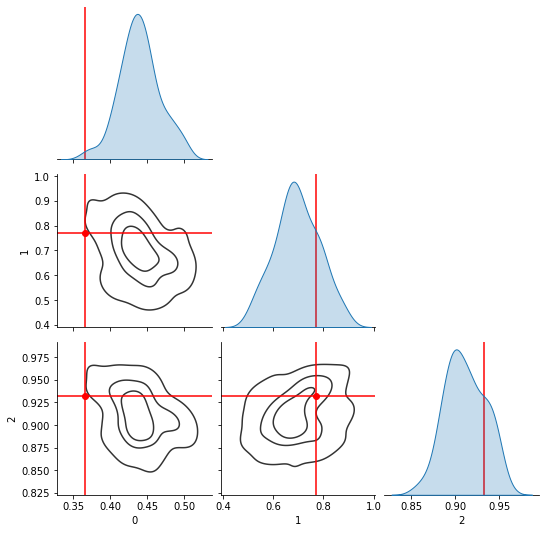

In [6]:
single_pos_sampler(pos_npe, x_obs=val_data[0],theta_fid=val_thetas[0])

100%|██████████| 200/200 [00:01<00:00, 179.00it/s]


[<Figure size 864x288 with 3 Axes>,
 <Figure size 648x288 with 3 Axes>,
 <Figure size 864x288 with 3 Axes>]

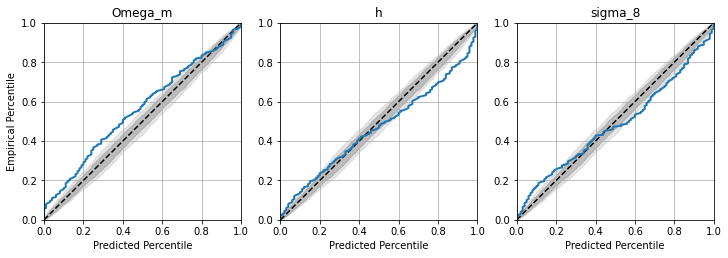

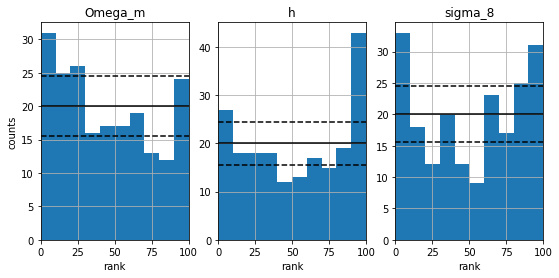

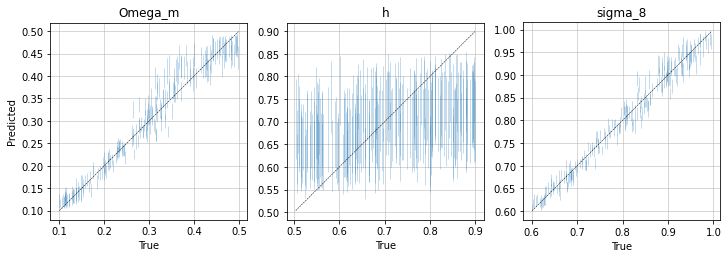

In [7]:
pos_coverage_sampler(pos_npe, x=val_data, theta=val_thetas)

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from corner import corner
# import sbibm
import os
import torch
import torch.nn as nn
import torch.optim as optim 
import normflows as nf
device='cuda'

In [9]:
from tools.noise_scheduler import noise_scheduler
from tools.loss import anneal_dsm_score_estimation
from tools.score_net import score_model_cond
from tools.sampling import annealed_langevin_dynamic_sampler
from tools.sbi_metrics import plot_ranks_histogram,plot_coverage,plot_predictions

In [10]:
samples=train_data.copy()
thetas=train_thetas.copy()
test_samples=val_data.copy()
test_thetas=val_thetas.copy()

# normalize data
# sample_mean = samples.mean(0)
# sample_std = samples.std(0)
# samples = (samples - sample_mean) / sample_std
# test_samples = (test_samples - sample_mean) / sample_std

# normalize parameters
thetas_min = thetas.min(0)
thetas_max = thetas.max(0)

thetas = (thetas - thetas_min) / (thetas_max - thetas_min)
test_thetas = (test_thetas - thetas_min) / (thetas_max - thetas_min)

# inverse normalization
def inv_normalize_samples(samples):
    return samples# * sample_std + sample_mean

def inv_normalize_thetas(thetas):
    return thetas* (thetas_max - thetas_min) + thetas_min



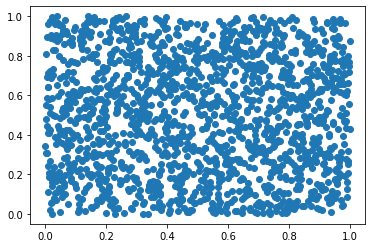

In [11]:
plt.scatter(thetas[:,0],thetas[:,1])

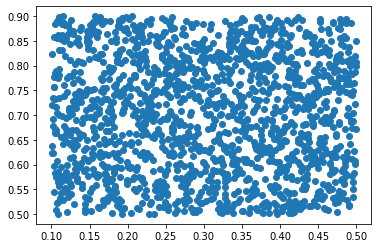

In [12]:
plt.scatter(train_thetas[:,0],train_thetas[:,1])

In [13]:
ns=noise_scheduler(1e-5,1e-2,100,schedule='sigmoid',var_norm=False)

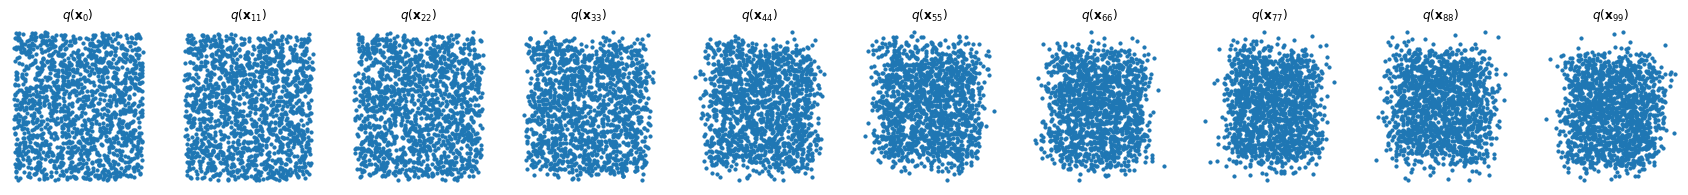

In [15]:
ns.visualize_noise(torch.tensor(thetas))

In [16]:
model = score_model_cond(100,x_dim=3,x_cond_dim=222).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [17]:
epochs=2000
# batch = (torch.tensor(samples, dtype=torch.float32).to(device),torch.tensor(thetas, dtype=torch.float32).to(device)
dataset=torch.tensor(samples).float().to(device)
thetas=torch.tensor(thetas).float().to(device)

#split into train and val
split_permutation = torch.randperm(dataset.size()[0])
split=0.8
train_indices = split_permutation[:int(split*dataset.size()[0])]
val_indices = split_permutation[int(split*dataset.size()[0]):]

dataset_train=dataset[train_indices]
thetas_train=thetas[train_indices]

dataset_val=dataset[val_indices]
thetas_val=thetas[val_indices]

batch_size=128
for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(dataset_train.size()[0])
    train_loss=0
    for i in range(0, dataset_train.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = thetas_train[indices]
        batch_x_cond = dataset_train[indices]

        labels = torch.randint(0, ns.n_steps, (batch_x.shape[0],)).to(device)

        loss = anneal_dsm_score_estimation(model, batch_x, labels, ns,samples_cond=batch_x_cond)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_loss+=loss.item()

    permutation = torch.randperm(dataset_val.size()[0])
    model.eval()
    val_loss=0
    best_val_loss=np.Inf
    for i in range(0, dataset_val.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = thetas_val[indices]
        batch_x_cond = dataset_val[indices]
        labels = torch.randint(0, ns.n_steps, (batch_x.shape[0],)).to(device)
        with torch.no_grad():
            loss = anneal_dsm_score_estimation(model, batch_x, labels, ns,samples_cond=batch_x_cond)
        val_loss+=loss.item()
    
    if val_loss<best_val_loss:
        best_val_loss=val_loss
        best_model=copy.deepcopy(model)

    if ((epoch % 100) == 0):
        print(train_loss,val_loss)

model=best_model

15.11549687385559 4.481893301010132
15.139969110488892 4.393019437789917
11.034908175468445 3.404294490814209
9.858514368534088 2.980791926383972
9.553407192230225 2.8218578100204468
9.13014417886734 2.6802077293395996
8.943519413471222 2.8274927735328674
8.955571591854095 2.7189189791679382
8.968968987464905 2.7465339303016663
8.1273752450943 2.7086341381073
8.700393378734589 2.436501622200012
8.599490404129028 2.522409677505493
8.122087597846985 2.7056962847709656
8.571479558944702 2.669971227645874
7.999856412410736 2.7738391160964966
8.304923951625824 2.5549288988113403
8.233217656612396 2.6111371517181396
8.456907331943512 2.413122296333313
7.9721070528030396 2.718429148197174
7.983064115047455 2.6536712646484375


In [18]:
model=best_model

In [19]:
sampler = annealed_langevin_dynamic_sampler(sigmas=ns.sigmas, 
                                            n_iter_each_T=100 , 
                                            score_fn=model, 
                                            device=device, 
                                            eps = 1e-5)

In [20]:
target_idx=np.random.randint(0,val_thetas.shape[0])
num_samples=10000


init_point=torch.randn(num_samples,3).to(device)+0.5

sample_cond=torch.tensor(np.repeat([test_samples[target_idx]],num_samples,axis=0),dtype=torch.float32).to(device)

dynamic=sampler.sample(init_point,sample_cond=sample_cond)

results=inv_normalize_thetas(dynamic[-1].cpu().detach().numpy())

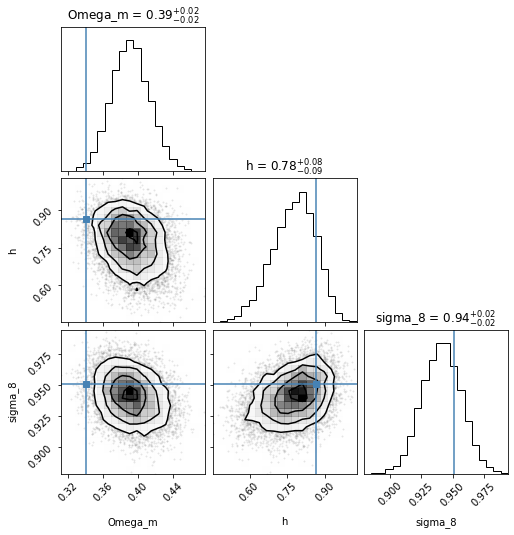

In [21]:
from corner import corner

corner(results,labels=[ 'Omega_m', 'h', 'sigma_8' ],show_titles=True,truths=inv_normalize_thetas(test_thetas[target_idx]));

In [22]:
# single_pos_sampler=PlotSinglePosterior(num_samples=10000,save_samples=True,out_dir='toy',sample_method='direct')
sbi_npe_sampler = DirectSampler(pos_npe)
sampler = annealed_langevin_dynamic_sampler(sigmas=ns.sigmas, 
                                            n_iter_each_T=100 , 
                                            score_fn=model, 
                                            device=device, 
                                            eps = 1e-5)

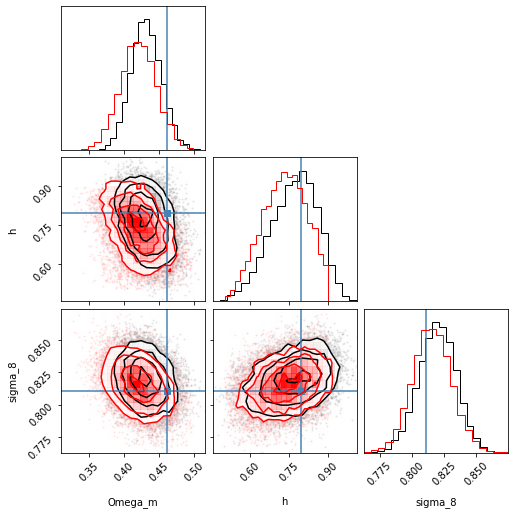

In [23]:
target_idx=np.random.randint(0,val_thetas.shape[0])
num_samples=10000


sbi_re = sbi_npe_sampler.sample(num_samples,val_data[target_idx])

# single_pos_sampler(pos_npe, x_obs=val_data[target_idx],theta_fid=val_thetas[target_idx]);
# sbi_re=np.load('toy/single_samples.npy')


init_point=torch.randn(num_samples,3).to(device)+0.5
sample_cond=torch.tensor(np.repeat([test_samples[target_idx]],num_samples,axis=0),dtype=torch.float32).to(device)
dynamic=sampler.sample(init_point,sample_cond=sample_cond)
sm_re=inv_normalize_thetas(dynamic[-1].cpu().detach().numpy())


fig=corner(sm_re,labels=[ 'Omega_m', 'h', 'sigma_8' ],truths=val_thetas[target_idx],hist_kwargs={'density':True});
corner(sbi_re,fig=fig,labels=[ 'Omega_m', 'h', 'sigma_8' ],color='red',hist_kwargs={'density':True});


In [24]:
sampler = annealed_langevin_dynamic_sampler(sigmas=ns.sigmas, 
                                            n_iter_each_T=100, 
                                            score_fn=model, 
                                            device=device, 
                                            eps = 1e-5)

In [25]:
num_samples=200
total_pos_samples=np.zeros((len(val_data),num_samples,3))
total_pos_samples_npe=np.zeros((len(val_data),num_samples,3))

for idx in range(len(val_data)):

    target_idx=idx
    init_point=torch.randn(num_samples,3).to(device)+0.5
    sample_cond=torch.tensor(np.repeat([test_samples[target_idx]],num_samples,axis=0),dtype=torch.float32).to(device)
    dynamic=sampler.sample(init_point,sample_cond=sample_cond)
    total_pos_samples[idx]=inv_normalize_thetas(dynamic[-1].cpu().detach().numpy())

    sbi_re = sbi_npe_sampler.sample(num_samples,val_data[target_idx])
    total_pos_samples_npe[idx]=sbi_re

    if idx%10==0:
        print(idx)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


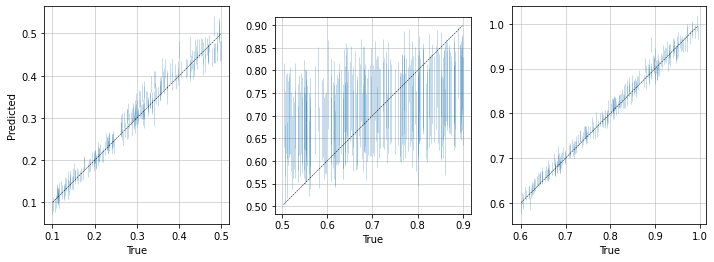

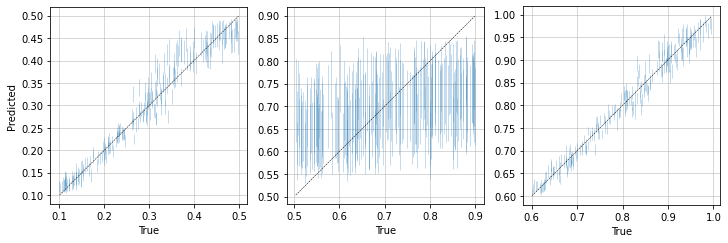

In [26]:
plot_predictions(total_pos_samples.transpose(1,0,2),val_thetas);
plot_predictions(total_pos_samples_npe.transpose(1,0,2),val_thetas);

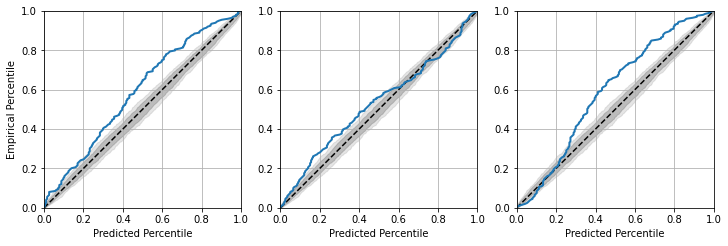

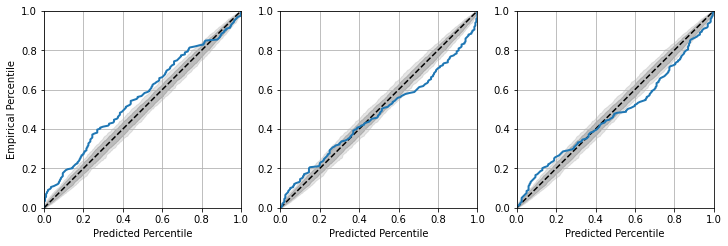

In [27]:
plot_coverage(total_pos_samples.transpose(1,0,2),val_thetas);
plot_coverage(total_pos_samples_npe.transpose(1,0,2),val_thetas);

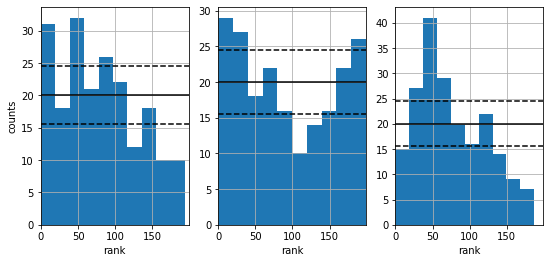

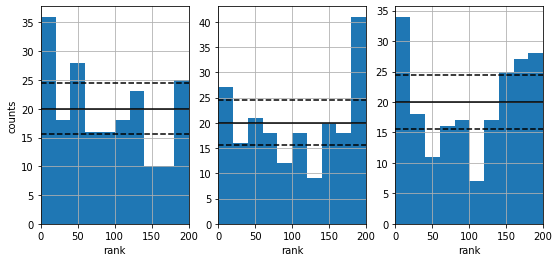

In [28]:
plot_ranks_histogram(total_pos_samples.transpose(1,0,2),val_thetas);
plot_ranks_histogram(total_pos_samples_npe.transpose(1,0,2),val_thetas);